In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread


In [33]:
cwd = os.getcwd()

In [34]:
os.chdir('/workspace/Mildew-Detection-in-Cherry-Leaves')

In [35]:
work_dir = os.getcwd()
work_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

### Set input directories

In [36]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [37]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [38]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape
image_shape = (dim1_mean, dim2_mean, 3)

In [39]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

### Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




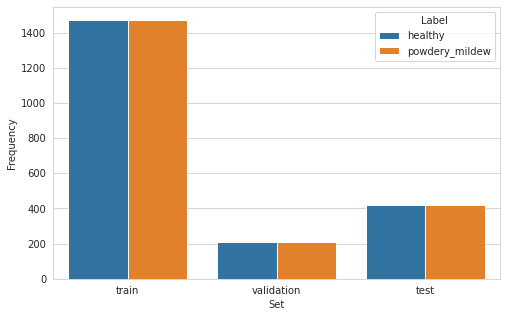

In [40]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

### Image data augmentation

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

In [43]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [44]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [45]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image

(20, 256, 256, 3)


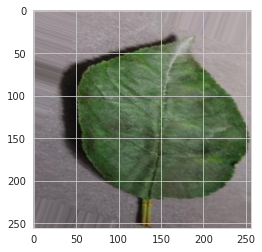

(20, 256, 256, 3)


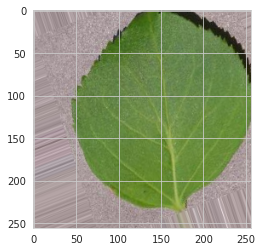

(20, 256, 256, 3)


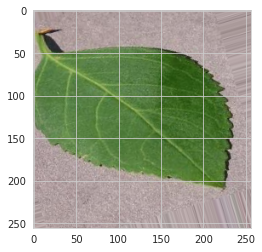

In [46]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(20, 256, 256, 3)


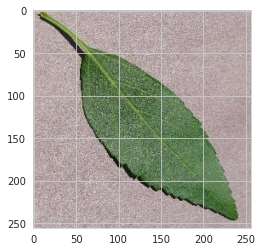

(20, 256, 256, 3)


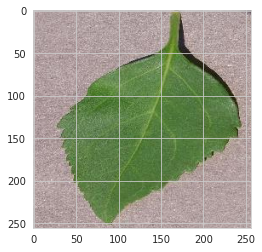

(20, 256, 256, 3)


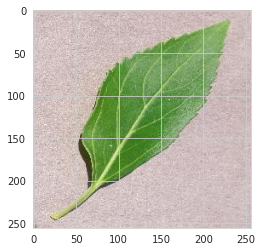

In [47]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


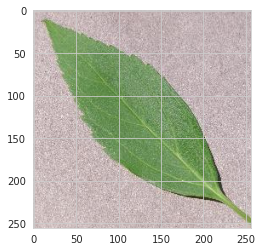

(20, 256, 256, 3)


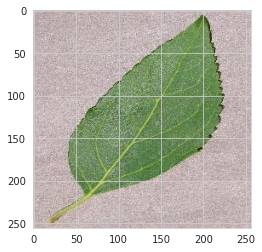

(20, 256, 256, 3)


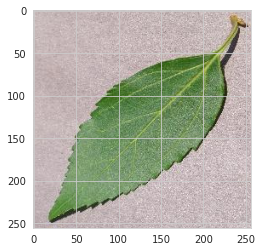

In [48]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [49]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

# Model creation

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


In [51]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=24, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=12, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=6, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [52]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 24)      672       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 24)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 12)      2604      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 8)         872       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 6)        

### Early Stopping

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fit model for model training

In [54]:
model = create_tf_model()
model.fit(train_set,
          epochs=8,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/8
147/147 [==============================] - 46s 311ms/step - loss: 0.3356 - accuracy: 0.8372 - val_loss: 0.1477 - val_accuracy: 0.9286
Epoch 2/8
147/147 [==============================] - 46s 309ms/step - loss: 0.0797 - accuracy: 0.9750 - val_loss: 0.0141 - val_accuracy: 0.9976
Epoch 3/8
147/147 [==============================] - 46s 309ms/step - loss: 0.0617 - accuracy: 0.9819 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/8
147/147 [==============================] - 46s 314ms/step - loss: 0.0377 - accuracy: 0.9911 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/8
147/147 [==============================] - 46s 311ms/step - loss: 0.0433 - accuracy: 0.9850 - val_loss: 9.9117e-04 - val_accuracy: 1.0000
Epoch 6/8
147/147 [==============================] - 46s 311ms/step - loss: 0.0422 - accuracy: 0.9863 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 7/8
147/147 [==============================] - 46s 313ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 4.7842e-04 - val_a

In [55]:
model.save('outputs/v1/mildew_detector_model.h5')

### Model Performace

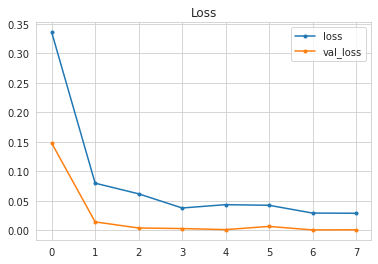

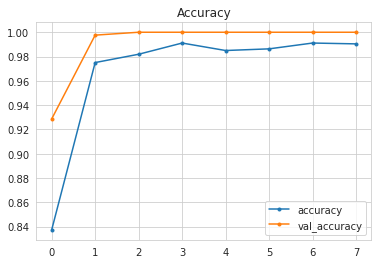

In [56]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [57]:

from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

In [58]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 3s 76ms/step - loss: 8.5759e-04 - accuracy: 1.0000


## Save evaluation pickle

In [59]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


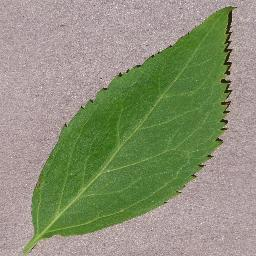

In [60]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select healthy or Powdery Mildew

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [61]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [62]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999854258758205
healthy
